# Proyecto entrega 1

### Integrantes
* Santiago Gomez
* Sebastian Martinez
* Johan Suarez

### Grupo
36

## Carga de datos

In [ ]:
%pip install -U "spacy>=3.8,<3.9"
%pip install "./es_core_news_sm-3.8.0-py3-none-any.whl" 

Note: you may need to restart the kernel to use updated packages.
Processing c:\users\santi\onedrive\escritorio\universidad\2025\2025-2\bi\proyecto-1\es_core_news_sm-3.8.0-py3-none-any.whl
es-core-news-sm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

vectorizer = TfidfVectorizer()
nlp = spacy.load("es_core_news_sm")
dfOriginal = pd.read_excel('Datos_proyecto.xlsx')
dfOriginal.info()
targetNames = dfOriginal['labels'].unique()
print("Categorías encontradas:", targetNames)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB
Categorías encontradas: [4 3 1]


## Exploración del texto

Principalmente observemos el formato inicial del dataset, con especial enfasis en la columna de textos

In [3]:
targetNames =  {1:'ODS 1',3:'ODS 3',4:'ODS 4'}
dfOriginal.head()
df = dfOriginal.copy()
df['textos'] = df['textos'].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


### Exploracion de longitudes de los textos presentados en el dataset

In [4]:
def columnasConteo(df : pd.DataFrame):
    df['Conteo'] = [len(x) for x in df['textos']]
    df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['textos']]
    df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['textos']]
columnasConteo(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"Además, la formación de especialistas en medic...",3,659,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1
4,Este grupo se centró en las personas que padec...,3,608,14,0


Veamos ahora los maximos, minimos y promedio de la longitud de los textos del dataset

In [5]:
def longitud(df: pd.DataFrame):
    maximo = df['Conteo'].max()
    minimo = df['Conteo'].min()
    promedio = int(df['Conteo'].mean())
    print(f'El maximo de longitud es: {maximo}')
    print(f'El minimo de longitud es: {minimo}')
    print(f'El promedio de longitud es: {promedio:.2f}')
    return maximo, minimo, promedio

El maximo de longitud es: 1492
El minimo de longitud es: 303
El promedio de longitud es: 683.00


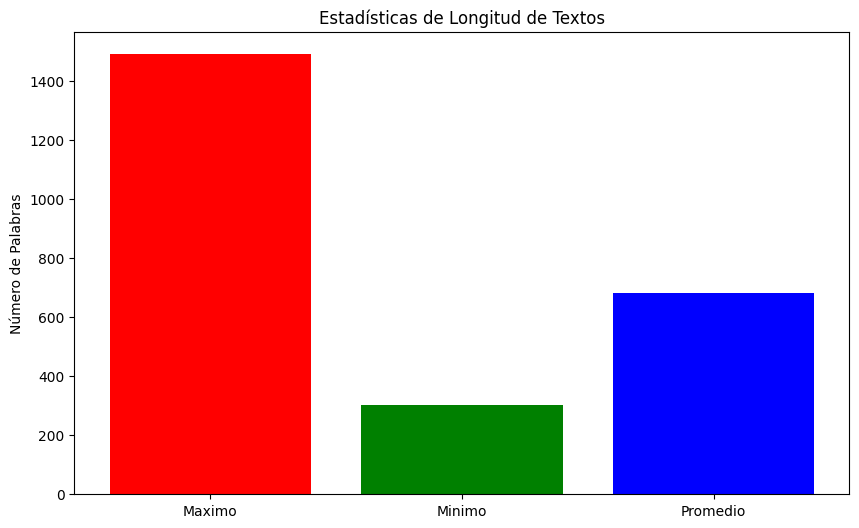

In [6]:
maximo, minimo, promedio = longitud(df)
plt.figure(figsize=(10,6))
plt.bar(['Maximo', 'Minimo', 'Promedio'], [maximo, minimo, promedio], color=['red', 'green', 'blue'])
plt.title('Estadísticas de Longitud de Textos')
plt.ylabel('Número de Palabras')
plt.show()


### Distribucion de la longitud

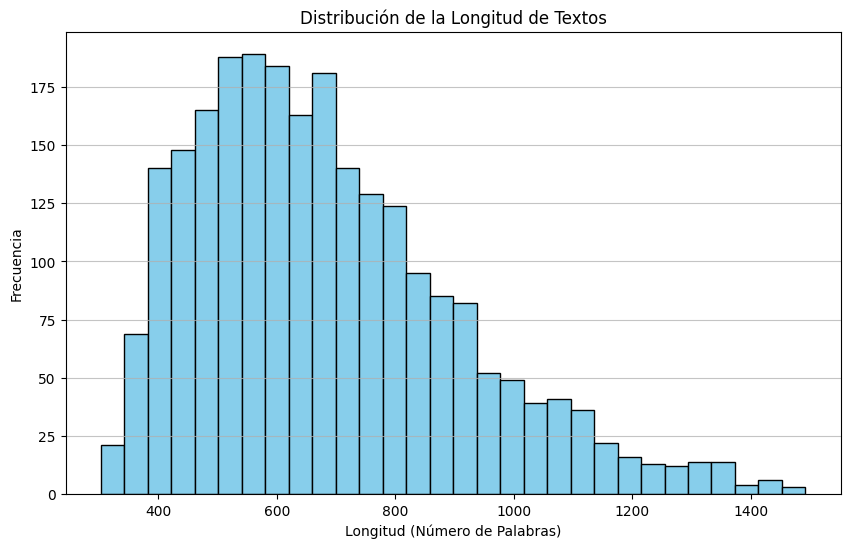

In [7]:

plt.figure(figsize=(10,6))
plt.hist(df['Conteo'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de Textos')
plt.xlabel('Longitud (Número de Palabras)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

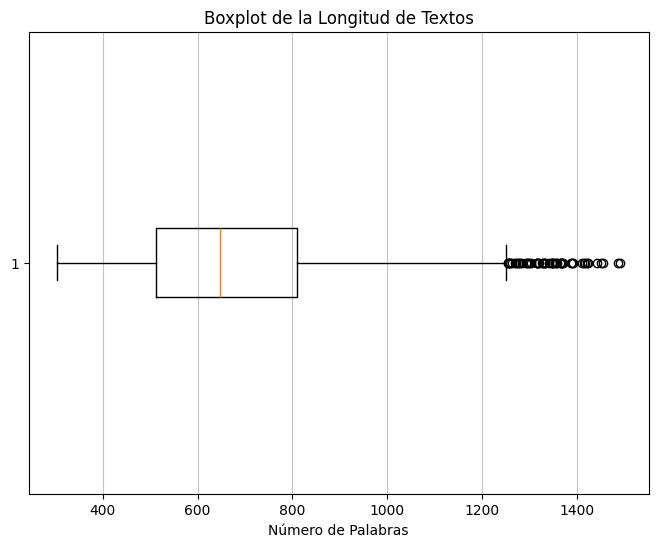

In [8]:
#Boxplot
plt.figure(figsize=(8,6))
plt.boxplot(df['Conteo'], vert=False)
plt.title('Boxplot de la Longitud de Textos')
plt.xlabel('Número de Palabras')
plt.grid(axis='x', alpha=0.75)
plt.show()

### Presencia de catracteres especiales

In [9]:
def especiales(df : pd.DataFrame):
    signos = r"(?:[!¡¿?;:'\"]|\.{3})"
    signosPresentes = df['textos'].str.contains(signos).sum()
    print(f'La cantidad de textos con signos de puntuación es: {signosPresentes}')
    print(f'El porcentaje de textos con signos de puntuación es: {signosPresentes/len(df)*100:.2f}%')
    especiales = r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])"
    especialesPresentes = df['textos'].str.contains(especiales).sum()
    print(f'La cantidad de textos con caracteres especiales es: {especialesPresentes}')
    print(f'El porcentaje de textos con caracteres especiales es: {especialesPresentes/len(df)*100:.2f}%')
    return signosPresentes, especialesPresentes


La cantidad de textos con signos de puntuación es: 596
El porcentaje de textos con signos de puntuación es: 24.59%
La cantidad de textos con caracteres especiales es: 1562
El porcentaje de textos con caracteres especiales es: 64.44%


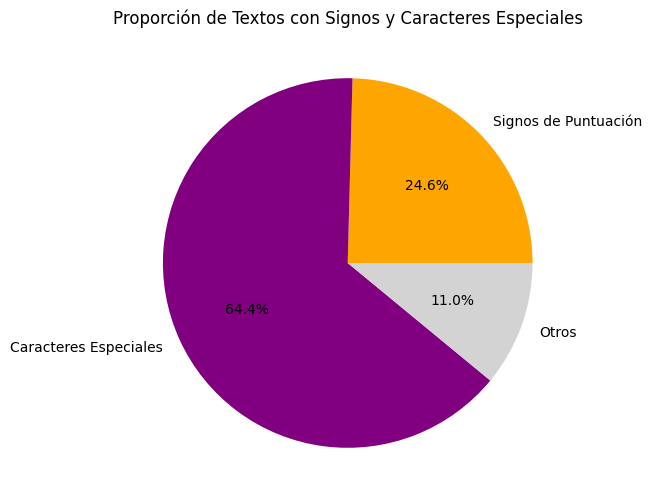

In [10]:
#Distribucion especiales
size = df['textos'].size
signosPresentes, especialesPresentes = especiales(df)
plt.figure(figsize=(8,6))
plt.pie([signosPresentes, especialesPresentes, size - signosPresentes - especialesPresentes], labels=['Signos de Puntuación', 'Caracteres Especiales', 'Otros'], autopct='%1.1f%%', colors=['orange', 'purple', 'lightgray'])
plt.title('Proporción de Textos con Signos y Caracteres Especiales')
plt.show()


### Distribucion de labels

,conteo
ODS 1,505
ODS 3,894
ODS 4,1025


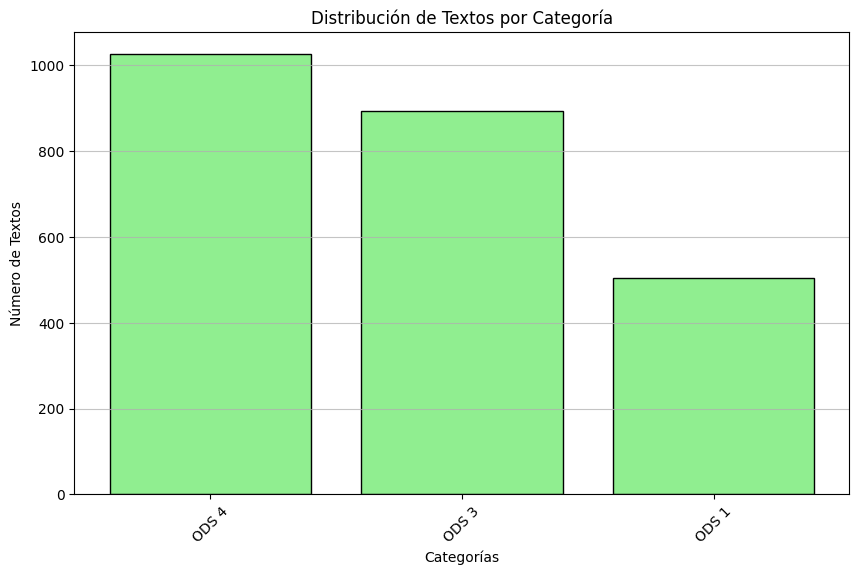

In [11]:
tiposComentario = df['labels'].value_counts().sort_index()
tiposComentario.index = [targetNames[i] for i in tiposComentario.index]
display(tiposComentario.to_frame('conteo'))

labelContador = df['labels'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(labelContador.index.map(targetNames), labelContador.values, color='lightgreen', edgecolor='black')
plt.title('Distribución de Textos por Categoría')
plt.xlabel('Categorías')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


<Figure size 1000x600 with 0 Axes>

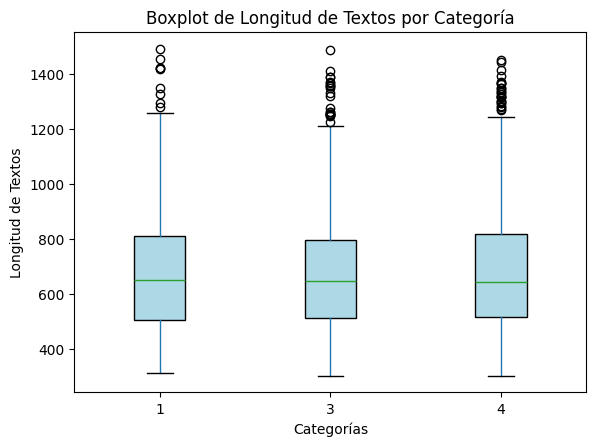

In [12]:
#Boxplot por categoria
plt.figure(figsize=(10,6))
df.boxplot(column='Conteo', by='labels', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Longitud de Textos por Categoría')
plt.suptitle('')  
plt.xlabel('Categorías')
plt.ylabel('Longitud de Textos')
plt.show()

### Limpieza

Procedemos a poner todo el dataset en un único formato

In [13]:
def todoAmin(df: pd.DataFrame):
    df['textos'] = df['textos'].str.lower()
todoAmin(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"además, la formación de especialistas en medic...",3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


Limpieza de caracteres especiales, signos y urls

In [14]:
def limpiza(df: pd.DataFrame):
    df['textos'] = df['textos'].str.replace(r"http[s]?://[^\s)]+", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[!¡¿?;:'\".,]|\.{3})", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"\s+", ' ', regex=True).str.strip()
limpiza(df)
df.head()


,textos,labels,Conteo,Max,Min
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1
2,además la formación de especialistas en medici...,3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


### Duplicados y Nulos

In [15]:
#Codigo dado en el notebook de la clase
def verNulosYDuplicados(df: pd.DataFrame):
    print("Valores nulos por columna:")
    display(df.isnull().sum())
    print("\nDuplicados (filas completas):", df.duplicated().sum())
    const_cols = [c for c in df.columns if df[c].nunique() == 1]
    print("Columnas constantes:", const_cols if const_cols else "Ninguna")
verNulosYDuplicados(df)

Valores nulos por columna:


textos    0
labels    0
Conteo    0
Max       0
Min       0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


### Tokenización

In [16]:
def tokenizacion(df: pd.DataFrame):
    columnaTokens = []
    for opinion in df['textos']:
        columnaTokens.append(opinion.split())
    df['tokens'] = columnaTokens
    return df
doc = tokenizacion(df)   
df.head()

,textos,labels,Conteo,Max,Min,tokens
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q..."


### Eliminación de tockens innecesarios, articulos, preposiciones, etc.

In [17]:
def quitar_stopwords(df: pd.DataFrame):
    stopwords = nlp.Defaults.stop_words
    tokensSinStopwords = []
    
    for lista in df['tokens']:
        tokens_filtrados = [tok for tok in lista if tok.lower() not in stopwords]
        tokensSinStopwords.append(tokens_filtrados)

    df['tokens_sin_innecesarios'] = tokensSinStopwords

quitar_stopwords(df)
df.head()


,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,..."


### Lematización

In [18]:
def lematizar_tokens(df: pd.DataFrame):
    lemas = []
    for lista in df['tokens_sin_innecesarios']:

        texto = " ".join(lista)
        doc = nlp(texto)
        lemas.append([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    
    df['lematizados'] = lemas
    return df

df = lematizar_tokens(df)
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


### Analisis de frecuencia de palabras

In [19]:
def frecuenciasPorPalabra(df: pd.DataFrame, vectorizer=vectorizer):
    textos = [" ".join(tokens) for tokens in df['lematizados']]
    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    pesosPromedio = np.asarray(X.mean(axis=0)).ravel()
    freq_df = pd.DataFrame({'Palabra': palabras, 'Peso Promedio': pesosPromedio})
    freq_df = freq_df.sort_values(by='Peso Promedio', ascending=False).reset_index(drop=True)
    return freq_df

freq_df = frecuenciasPorPalabra(df)
freq_df.head(10)


,Palabra,Peso Promedio
0,salud,0.027882
1,educación,0.025477
2,país,0.025256
3,escuela,0.024556
4,atención,0.024052
5,pobreza,0.022993
6,sistema,0.018521
7,año,0.018438
8,nivel,0.018389
9,servicio,0.017348


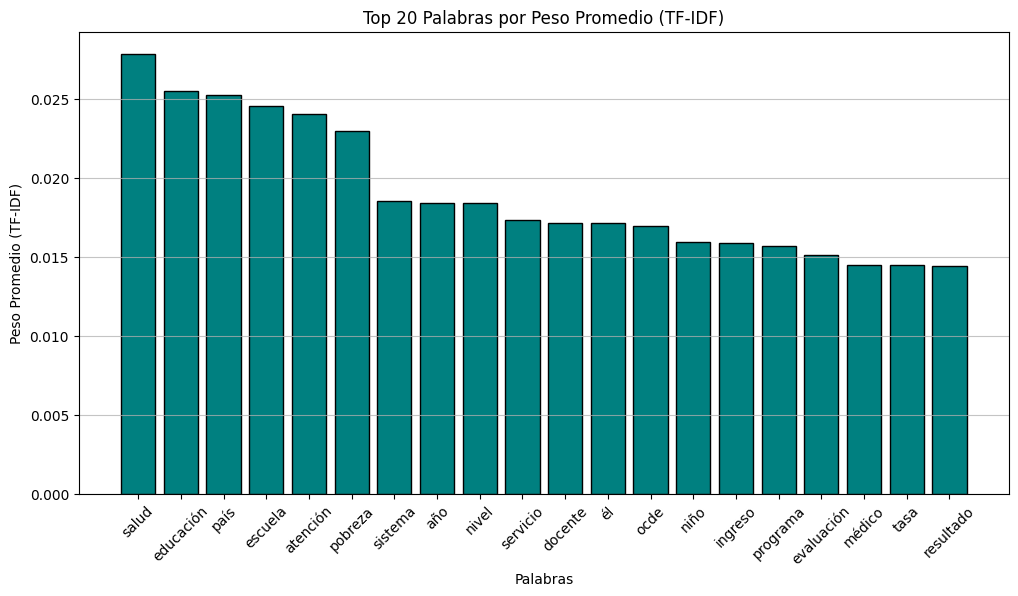

In [20]:
#plot frecuencias
plt.figure(figsize=(12,6))
plt.bar(freq_df['Palabra'][:20], freq_df['Peso Promedio'][:20], color='teal', edgecolor='black')
plt.title('Top 20 Palabras por Peso Promedio (TF-IDF)')
plt.xlabel('Palabras')
plt.ylabel('Peso Promedio (TF-IDF)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Modelo de Clasificación SVM lineal

Se construyó y evaluó el 3er modelo para clasificar las opiniones de la ciudadanía en función de los ODS 1, 3 y 4. Se eligió un SVM lineal (LinearSVC) junto con un vectorizador TF-IDF de
uni-gramas y bi-gramas. Esto porque el vectorizador permite representar los textos de forma numérica considerando no solo la frecuencia de cada término, sino su importancia,
dando más peso a palabras informativas y menos a palabras muy frecuentes. Además, SVM lineal es adecuado para clasificación de texto en alta dimensión.


## Preparación de datos

En este paso unimos los tokens lematizados de cada documento en un solo string,
extraemos las etiquetas y realizamos el split en entrenamiento y prueba (80/20).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

plt.rcParams["figure.dpi"] = 120

def nombre_clase(c):
    try:
        return targetNames.get(c, str(c))
    except Exception:
        return str(c)

textos = [" ".join(t) for t in df["lematizados"]]
labels = df["labels"].values
classes_sorted = np.sort(np.unique(labels))
classes_names  = [nombre_clase(c) for c in classes_sorted]

X_train, X_test, y_train, y_test = train_test_split(
    textos, labels, test_size=0.2, random_state=42, stratify=labels
)

## Vectorización TF-IDF

Se convierte cada texto en un vector TF-IDF usando uni-gramas y bi-gramas, eliminando términos demasiado raros o demasiado frecuentes.

In [ ]:
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    analyzer="word",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    max_features=8000
)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

## Entrenamiento del modelo SVM lineal

Se entrena un LinearSVC buscando el mejor hiperparámetro `C` mediante
validación cruzada estratificada y optimizando la métrica F1-macro.


In [ ]:
base = LinearSVC(class_weight="balanced", random_state=42)
param_grid = {"C": [0.1, 0.5, 1, 2, 5, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(base, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1)
grid.fit(Xtr, y_train)
clf = grid.best_estimator_

print(f"Mejor C: {grid.best_params_['C']} | F1-macro (CV): {grid.best_score_:.4f}")

## Métricas de evaluación
Se reportan:
- Accuracy 
- Precision, Recall y F1-score por clase (train y test)  
- F1-macro y micro para el balance general  
- Matriz de confusión
- F1 por clase (gráfico de barras)
- Curva ROC y AUC (micro-average en caso multiclase)  

Además, se muestran los Top 15 términos más relevantes por clase para
interpretar el modelo, y se genera un CSV con los resultados del conjunto de prueba
incluyendo las predicciones y los scores de decisión.

Mejor C: 1 | F1-macro (CV): 0.9755

=== Classification Report (TRAIN) ===
              precision    recall  f1-score   support

       ODS 1       1.00      1.00      1.00       404
       ODS 3       1.00      1.00      1.00       715
       ODS 4       1.00      1.00      1.00       820

    accuracy                           1.00      1939
   macro avg       1.00      1.00      1.00      1939
weighted avg       1.00      1.00      1.00      1939



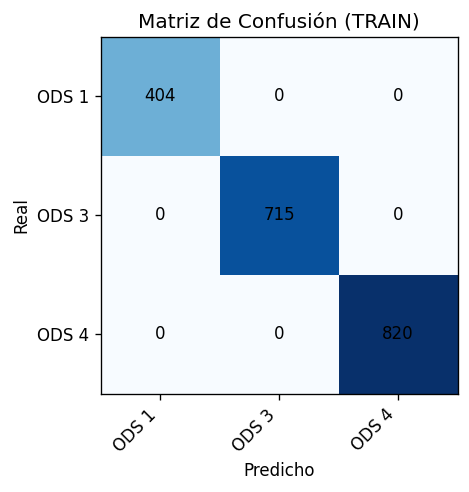


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

       ODS 1       0.96      0.94      0.95       101
       ODS 3       0.96      0.98      0.97       179
       ODS 4       0.99      0.98      0.98       205

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



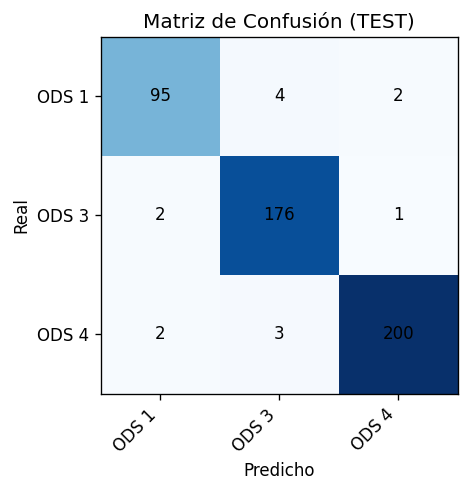

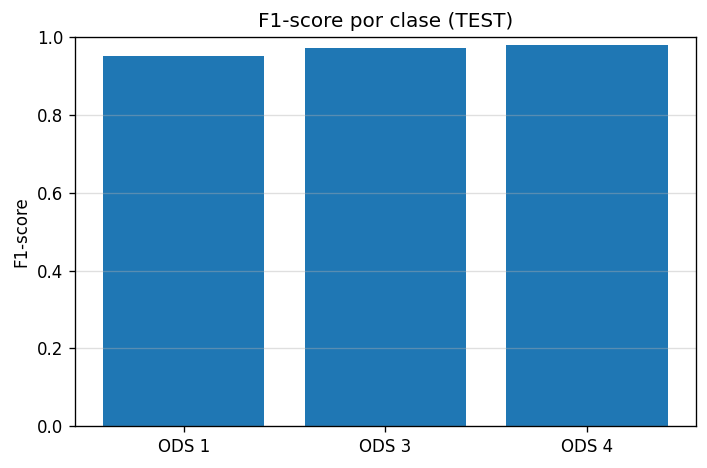

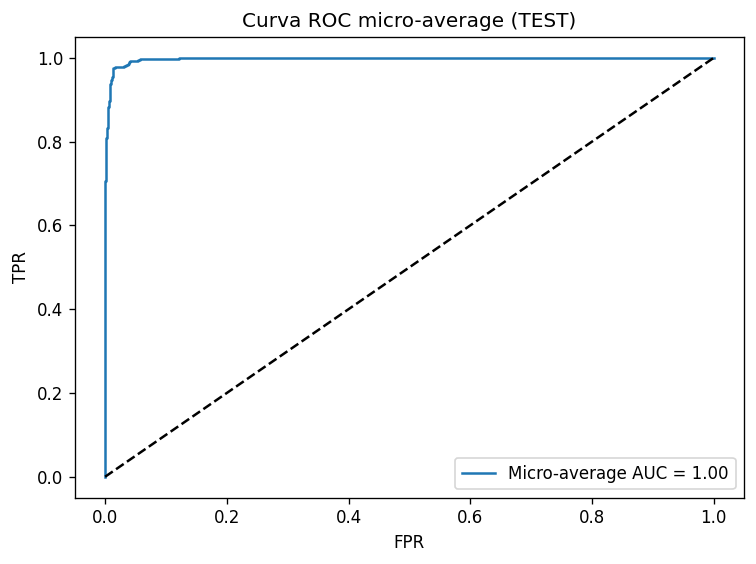


Top 15 términos para ODS 1


,clase,termino,peso
0,ODS 1,pobreza,4.702411
1,ODS 1,pobre,2.709210
2,ODS 1,pobrezar,2.378649
3,ODS 1,hogar,1.592232
4,ODS 1,ingreso,1.525329
5,ODS 1,privacion,1.495633
6,ODS 1,proteccion social,1.475519
7,ODS 1,social,1.247439
8,ODS 1,proteccion,1.181574
9,ODS 1,empleo,1.175234


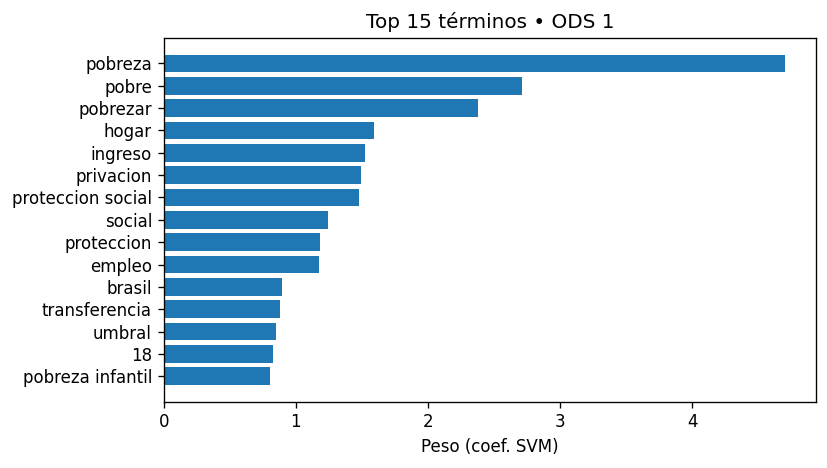


Top 15 términos para ODS 3


,clase,termino,peso
0,ODS 3,salud,3.881389
1,ODS 3,medico,2.233747
2,ODS 3,atencion,1.865589
3,ODS 3,sanitario,1.861848
4,ODS 3,enfermedad,1.859288
5,ODS 3,paciente,1.815226
6,ODS 3,mental,1.269323
7,ODS 3,hospital,1.266145
8,ODS 3,alcohol,1.240456
9,ODS 3,mortalidad,1.226056


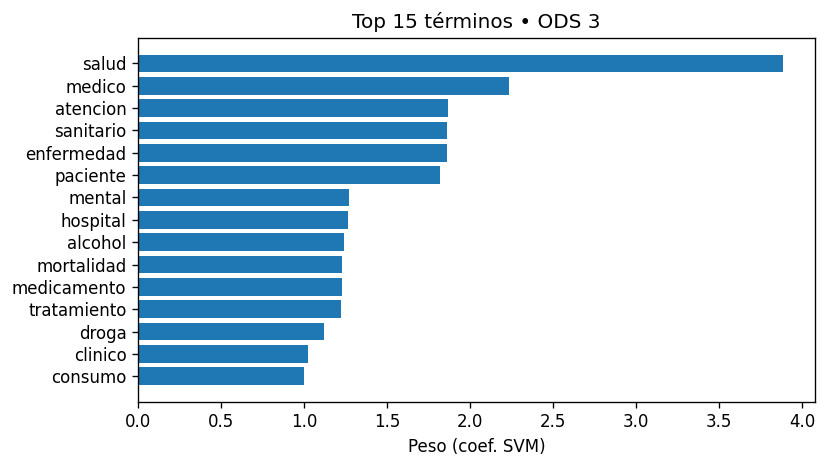


Top 15 términos para ODS 4


,clase,termino,peso
0,ODS 4,educacion,3.123979
1,ODS 4,escuela,2.748537
2,ODS 4,educativo,2.261743
3,ODS 4,estudiant,1.858124
4,ODS 4,docente,1.820946
5,ODS 4,aprendizaje,1.689402
6,ODS 4,escolar,1.674614
7,ODS 4,alumno,1.587900
8,ODS 4,profesor,1.472845
9,ODS 4,maestro,1.274232


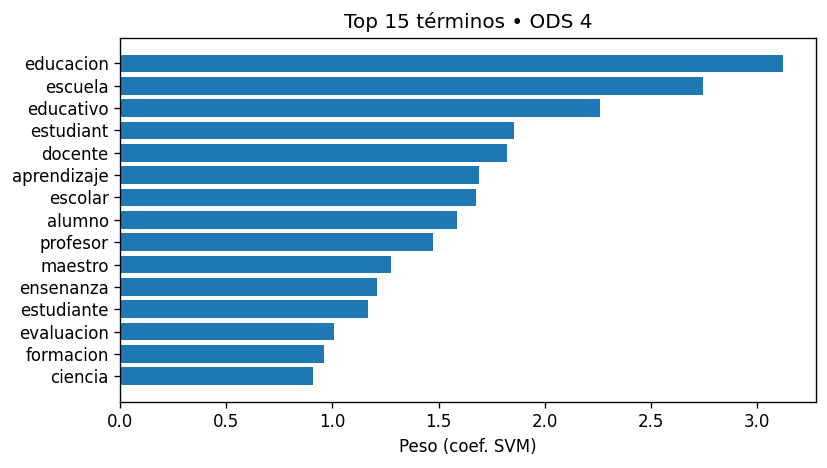


CSV de resultados guardado en: resultados_svm_tfidf_completo.csv


In [ ]:
y_pred_train = clf.predict(Xtr)
y_pred_test  = clf.predict(Xte)

print("\n=== Classification Report (TRAIN) ===")
print(classification_report(y_train, y_pred_train, target_names=classes_names))
cm_train = confusion_matrix(y_train, y_pred_train, labels=classes_sorted)
fig, ax = plt.subplots(figsize=(5.6, 4.2))
im = ax.imshow(cm_train, cmap="Blues")
ax.set_title("Matriz de Confusión (TRAIN)")
ax.set_xticks(range(len(classes_sorted))); ax.set_yticks(range(len(classes_sorted)))
ax.set_xticklabels(classes_names, rotation=45, ha="right"); ax.set_yticklabels(classes_names)
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        ax.text(j, i, cm_train[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout(); plt.show()

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_pred_test, target_names=classes_names))
cm_test = confusion_matrix(y_test, y_pred_test, labels=classes_sorted)
fig, ax = plt.subplots(figsize=(5.6, 4.2))
im = ax.imshow(cm_test, cmap="Blues")
ax.set_title("Matriz de Confusión (TEST)")
ax.set_xticks(range(len(classes_sorted))); ax.set_yticks(range(len(classes_sorted)))
ax.set_xticklabels(classes_names, rotation=45, ha="right"); ax.set_yticklabels(classes_names)
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, cm_test[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout(); plt.show()

_, _, f1_por_clase, _ = precision_recall_fscore_support(y_test, y_pred_test, labels=classes_sorted)
plt.figure(figsize=(6,4))
plt.bar(classes_names, f1_por_clase)
plt.title("F1-score por clase (TEST)")
plt.ylabel("F1-score"); plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.4)
plt.tight_layout(); plt.show()

scores = clf.decision_function(Xte)
y_test_bin = label_binarize(y_test, classes=classes_sorted)
if y_test_bin.shape[1] == 1:
    fpr, tpr, _ = roc_curve(y_test_bin, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "k--")
    plt.title("Curva ROC (TEST)")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()
else:
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), np.atleast_2d(scores).ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Micro-average AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "k--")
    plt.title("Curva ROC micro-average (TEST)")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()

feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_
top_k = 15
tops_frames = []
for pos, cls in enumerate(clf.classes_):
    idx = np.argsort(coefs[pos])[::-1][:top_k]
    df_top = pd.DataFrame({
        "clase": nombre_clase(cls),
        "termino": feature_names[idx],
        "peso": coefs[pos][idx]
    })
    tops_frames.append(df_top)
    print(f"\nTop {top_k} términos para {nombre_clase(cls)}")
    display(df_top)
    plt.figure(figsize=(7,4))
    plt.barh(df_top["termino"][::-1], df_top["peso"][::-1])
    plt.title(f"Top {top_k} términos • {nombre_clase(cls)}")
    plt.xlabel("Peso (coef. SVM)")
    plt.tight_layout(); plt.show()

df_out = pd.DataFrame({"texto": X_test, "y_true": y_test, "y_pred": y_pred_test})
if "scores" in locals():
    sc = np.atleast_2d(scores)
    if sc.ndim == 2:
        for j, cls in enumerate(clf.classes_):
            df_out[f"score_{cls}"] = sc[:, j] if sc.shape[1] > 1 else sc[:, 0]
        df_out["score_max"] = sc.max(axis=1)

df_out.to_csv("resultados_svm_tfidf_completo.csv", index=False, encoding="utf-8")


## Conclusiones

El modelo SVM lineal alcanzó un F1-macro de 0.9755 en el conjunto de prueba.
Las palabras más relevantes por clase van de acuerdo con el contexto del problema.
Por ejemplo, términos relacionados con salud aparecen en ODS 3.
Respceto al uso, la organización puede usar este modelo para clasificar automáticamente nuevas opiniones,
ahorrando tiempo en el análisis manual y facilitando la priorización de acciones
relacionadas con la Agenda 2030.  
